In [76]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import glob
import os
from tensorflow.keras.callbacks import TensorBoard
import time
import pickle
import matplotlib.pyplot as plt

# set parameters

In [77]:
batch_size = 32
epoch = 150
img_height = 300
img_width = 300
root = '/A_LUAD/project/final_project'
name = '2-class-downsample{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='/A_LUAD/project/final_project/logs/{}'.format(name))

# load data

In [78]:
train_dir = '/A_LUAD/project/final_project/data/temp/down_train'
val_dir = '/A_LUAD/project/final_project/data/temp/down_val'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

Found 1796 files belonging to 2 classes.
Found 477 files belonging to 2 classes.


# build model

In [79]:
class ConfusionMatrixMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the running average of the confusion matrix
    """
    def __init__(self, num_classes, **kwargs):
        super(ConfusionMatrixMetric,self).__init__(name='confusion_matrix_metric',**kwargs) # handles base args (e.g., dtype)
        self.num_classes=num_classes
        self.total_cm = self.add_weight("total", shape=(num_classes,num_classes), initializer="zeros")
        
    def reset_state(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))
            
    def update_state(self, y_true, y_pred,sample_weight=None):
        self.total_cm.assign_add(self.confusion_matrix(y_true,y_pred))
        return self.total_cm
        
    def result(self):
        return self.process_confusion_matrix()
    
    def confusion_matrix(self,y_true, y_pred):
        """
        Make a confusion matrix
        """
        y_pred=tf.argmax(y_pred,1)
        cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=self.num_classes)
        return cm
    
    def process_confusion_matrix(self):
        "returns precision, recall and f1 along with overall accuracy"
        cm=self.total_cm
        diag_part=tf.linalg.diag_part(cm)
        precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
        recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
        f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
        return precision,recall,f1
    
    def fill_output(self,output):
        results=self.result()
        for i in range(self.num_classes):
            output['precision_{}'.format(i)]=results[0][i]
            output['recall_{}'.format(i)]=results[1][i]
            output['F1_{}'.format(i)]=results[2][i]
    # def get_config(self):
    #     config = super(ConfusionMatrixMetric, self).get_config()
    #     config.update({"num_classes": self.num_classes,"total_cm": self.total_cm})
    #     return config
    
class MySequential(keras.Sequential):
    
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.

        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value.
            # The loss function is configured in `compile()`.
            loss = self.compiled_loss(
                y,
                y_pred,
                regularization_losses=self.losses,
            )

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, y_pred)
        output={m.name: m.result() for m in self.metrics[:-1]}
        if 'confusion_matrix_metric' in self.metrics_names:
            self.metrics[-1].fill_output(output)
        return output
        
        
    def test_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.

        x, y = data

        y_pred = self(x, training=False)  # Forward pass
        # Compute the loss value.
        # The loss function is configured in `compile()`.
        loss = self.compiled_loss(
            y,
            y_pred,
            regularization_losses=self.losses,
        )

        self.compiled_metrics.update_state(y, y_pred)
        output={m.name: m.result() for m in self.metrics[:-1]}
        if 'confusion_matrix_metric' in self.metrics_names:
            self.metrics[-1].fill_output(output)    
        return output

## with data augmentatiom

In [80]:
data_augmentation = keras.Sequential(
  [
    keras.layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

####### model
num_classes = 2
# Dropout
model = MySequential([
  data_augmentation,
  keras.layers.experimental.preprocessing.Rescaling(1./300),
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Dropout(0.2),
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(num_classes)
])
loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=keras.optimizers.Adam()
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy',ConfusionMatrixMetric(2)])

# train

In [81]:
# es=keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=100)
history=model.fit(train_ds,validation_data=val_ds,epochs=epoch, verbose=1, callbacks=[tensorboard])

Epoch 1/150
57/57 [==============================] - 10s 124ms/step - loss: 0.6941 - accuracy: 0.5356 - precision_0: 0.5380 - recall_0: 0.9690 - F1_0: 0.6917 - precision_1: 0.2937 - recall_1: 0.0202 - F1_1: 0.0373 - val_loss: 0.6555 - val_accuracy: 0.7904 - val_precision_0: 0.7904 - val_recall_0: 1.0000 - val_F1_0: 0.8829 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_F1_1: 0.0000e+00
Epoch 2/150
57/57 [==============================] - 6s 109ms/step - loss: 0.6885 - accuracy: 0.5401 - precision_0: 0.5501 - recall_0: 1.0000 - F1_0: 0.7097 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - F1_1: 0.0000e+00 - val_loss: 0.6397 - val_accuracy: 0.7904 - val_precision_0: 0.7904 - val_recall_0: 1.0000 - val_F1_0: 0.8829 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_F1_1: 0.0000e+00
Epoch 3/150
57/57 [==============================] - 6s 110ms/step - loss: 0.6822 - accuracy: 0.5585 - precision_0: 0.5414 - recall_0: 0.9587 - F1_0: 0.6915 - precision_1: 0.4484 - 

# results

## loading test data

In [82]:
import glob
group1 = glob.glob('/A_LUAD/project/final_project/data/temp/two_test/group1/*.png')
group2 = glob.glob('/A_LUAD/project/final_project/data/temp/two_test/group2/*.png')

data = []
labels = []

for i in group1:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (300,300))
    image=np.array(image)
    data.append(image)
    labels.append(0)
for i in group2:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (300,300))
    image=np.array(image)
    data.append(image)
    labels.append(1)

x_test = np.array(data)
y_test = np.array(labels)

## save eva results

In [83]:
name

'2-class-downsample1674160776'

In [84]:
######### evaluate model
testname = name + '_test'
results = model.evaluate(x_test, y_test)

32/32 [==============================] - 2s 45ms/step - loss: 1.9574 - accuracy: 0.6076 - precision_0: 0.7907 - recall_0: 0.5725 - F1_0: 0.6529 - precision_1: 0.2048 - recall_1: 0.2168 - F1_1: 0.2104


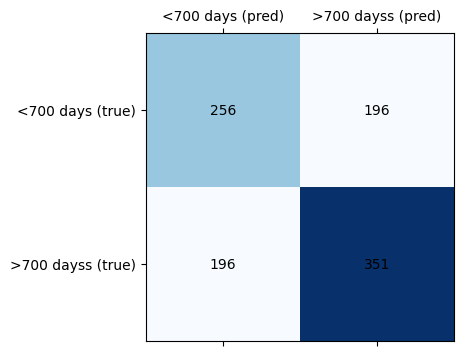

In [85]:
test_path = '/A_LUAD/project/final_project/test_results'
## not sure
# test_name = name + '_pred.pickle'
# with open(os.path.join(test_path,test_name), 'wb') as file_pi:
#     pickle.dump(y_pred_lbls, file_pi)

######### visualization
y_pred=model.predict(x_test)
y_pred_lbls=np.argmax(y_pred,-1)

lbls=dict(map(lambda x: x.split('\t'),"""0 	<700 days
1 	>700 dayss""".split('\n')))
lbls={int(k):v for k,v in lbls.items()}

cm=ConfusionMatrixMetric(num_classes)
_=cm.update_state(y_test,y_pred)
fig, ax = plt.subplots(figsize=(6,4))
cm_matrix = cm.total_cm.numpy().astype(np.int32)
ax.matshow(cm_matrix, cmap=plt.cm.Blues)

for i in range(num_classes):
    for j in range(num_classes):
        c = cm_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center')
plt.xticks(range(num_classes),['{} ({})'.format(lbls[i],'pred') for i in range(num_classes)])
plt.yticks(range(num_classes),['{} ({})'.format(lbls[i],'true') for i in range(num_classes)])
plt_name = name + '_loss'+str(round(results[0],2)) + '_acc'+str(round(results[1],2))+ '_p1_'+str(round(results[2],2))+ '_r1_'+str(round(results[3],2))+ '_f11_'+str(round(results[4],2))+ '_p2_'+str(round(results[5],2))+ '_r2_'+str(round(results[6],2))+ '_f12_'+str(round(results[7],2))+'_test.png'
plt.savefig(os.path.join(test_path, plt_name))
# plt.show()